# CIS4930 -- Final Project
## Developed by: Chloe Fandino (Team Leader), Ashley James, Madelyne Wirbel, Chloe Nolan, Christopher Enlow

## Data Preprocessing

### Imports

In [180]:
# imports here :)

# TODO: DELETE ---> any imports that don't end up getting used by the end of the project !!!!

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector

from imblearn.over_sampling import SMOTE, SMOTENC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

### Loading the data

In [181]:
df = pd.read_csv('OnlineNewsPopularity.csv') # import the data from the csv file --> convert to df

### Exploration of the dataset

In [182]:
# pd.set_option('display.max_rows', 100) # for purposes of looking at data --> need to see all rows

# basic intitial looks at the dataset
print(df.shape)

print(df.info())

(39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords       

In [183]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

In [184]:
print(df.columns.tolist()) # print out all of the available columns

['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', '

In [185]:
df.isnull().sum() # null values? --> NONE :)

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64

In [186]:
df.duplicated().sum() # duplicate values? --> NONE :)

np.int64(0)

In [187]:
# check if any infinities exist in the dataframe
numeric_df = df.select_dtypes(include=[np.number])

has_inf = np.isinf(numeric_df.to_numpy()).any()

print(has_inf) # will need to handle in cleaning
inf_cols = numeric_df.columns[np.isinf(numeric_df.to_numpy()).any(axis=0)].tolist()
print("Columns with inf:", inf_cols)

False
Columns with inf: []


### Cleaning the data

In [188]:
# # exploration of potentially non-predictive features
# df['url'].nunique() == len(df) # each example has a different url --> not needed in the dataset
# df = df.drop(columns = ['url'])

# df = df.drop(columns = ['timedelta']) # number of days since posted until added to the dataset --> no predictive qualities
df = df.drop(columns=['url', 'timedelta'], errors='ignore')
#feature engineering
df['rate_positive_words'] = df['global_rate_positive_words'] / (df['n_tokens_content'] + 1)
df['rate_negative_words'] = df['global_rate_negative_words'] / (df['n_tokens_content'] + 1)
df['emotional_polarity'] = df['global_sentiment_polarity'].abs()
df['title_body_sentiment_ratio'] = df['title_sentiment_polarity'] / (df['global_sentiment_polarity'] + 0.01)

In [ ]:
# CHLOE target creation
median_shares = df['shares'].median()
print(f"Splitting data at median shares: {median_shares}")

def categorize(x):
    return 1 if x > median_shares else 0

df['y'] = df['shares'].apply(categorize)

# define X and y 
X = df.drop(columns=['shares', 'y'])
y = df['y']

binary_cols = [col for col in X.columns if "data_channel" in col or "weekday" in col or "is_weekend" in col]
# ensure binary cols are actually integers
for col in binary_cols:
    X[col] = X[col].astype(int)

numeric_cols = [col for col in X.columns if col not in binary_cols]

Splitting data at median shares: 1400.0


In [190]:
# Identify binary columns and ensure they are ints
# binary_cols = [col for col in df.columns 
#                if col.startswith("data_channel_is_") or col.startswith("weekday_is_")]

# # ensure binary indicator columns are integers
# df.columns = df.columns.str.strip()
# print("Binary indicator columns:", binary_cols)

# for col in binary_cols:
#     df[col] = df[col].astype(int)

# df[binary_cols].dtypes.head()

In [191]:
# CHLOE here is where we actually do test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
#CHLOE pearson correlation coefficient
corr_matrix = X_train[numeric_cols].corr(method='pearson').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print(f"Dropping {len(to_drop)} columns due to correlation: {to_drop}")

X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
numeric_cols = [c for c in numeric_cols if c not in to_drop]

Dropping 6 columns due to correlation: ['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min', 'kw_max_max', 'self_reference_avg_sharess', 'emotional_polarity']


In [193]:
#CHLOE handling skew and outliers
scaler = RobustScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
#CHLOE TRAIN SMOTE NAN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

#CLASS BALANCING (SMOTE)
cat_indices = [X_train.columns.get_loc(c) for c in binary_cols if c in X_train.columns]
print("Applying SMOTE...")
sm = SMOTENC(categorical_features=cat_indices, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

Applying SMOTE...


In [195]:
#CHLOE FEATURE SELECTION
cat_indices = [X_train.columns.get_loc(c) for c in binary_cols if c in X_train.columns]
print("Running Fast Feature Selection...")
selector_model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
selector_model.fit(X_train_res, y_train_res)

selection = SelectFromModel(selector_model, threshold="1.25*median", prefit=True)
X_train_selected = selection.transform(X_train_res)
X_test_selected = selection.transform(X_test)

selected_features_names = X_train_res.columns[selection.get_support()]
print(f"Selected {len(selected_features_names)} features.")

Running Fast Feature Selection...


c:\Users\Chloe\anaconda3\envs\CIS4930\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Chloe\anaconda3\envs\CIS4930\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected 22 features.


Training XGBoost...

Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.66      0.64      0.65      4017
       Viral       0.64      0.66      0.65      3912

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929



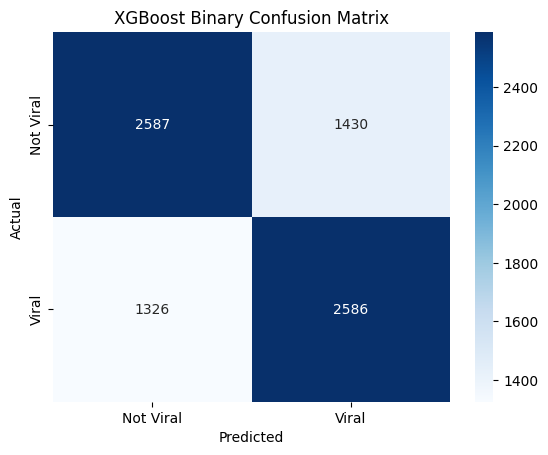

In [ ]:
print("Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='binary:logistic'
)

xgb_model.fit(X_train_selected, y_train_res)

y_pred_xgb = xgb_model.predict(X_test_selected)

#evaluate
labels = ["Not Viral", "Viral"] 

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb, target_names=labels))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Binary Confusion Matrix")
plt.show()

In [197]:
# handling inf
# df = df.replace([np.inf, -np.inf], np.nan)
# df = df.dropna()
# print("Dataset shape after removing inf/NaN:", df.shape)

#### Remove highly correlated features

In [198]:
# # test of feature correlation --> highly correlated features do not need to both be in dataset
# df_correlation = df.corr()

# sns.heatmap(df_correlation, cmap = 'coolwarm', center = 0)
# plt.title("Correlation Heatmap")

In [199]:
# X_corr = df.drop(columns=['shares'])
# y_corr = df['shares']

# def drop_correlated_by_importance(X, y, threshold=0.7, n_estimators=50, protected_cols=[]):
#     model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
#     model.fit(X, y)
#     importances = pd.Series(model.feature_importances_, index=X.columns)

#     corr_matrix = X.corr().abs()
#     upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#     corr_pairs = upper.stack().reset_index()
#     corr_pairs.columns = ['feat1', 'feat2', 'corr']
#     corr_pairs = corr_pairs[corr_pairs['corr'] > threshold]

#     to_drop = set()
#     for _, row in corr_pairs.iterrows():
#         if row['feat1'] in protected_cols or row['feat2'] in protected_cols: # we dont want to drop binary indicator cols
#             continue
#         if importances[row['feat1']] >= importances[row['feat2']]:
#             to_drop.add(row['feat2'])
#         else:
#             to_drop.add(row['feat1'])
#     return list(to_drop)

In [200]:
# columns_to_drop = drop_correlated_by_importance(
#     X_corr, y_corr, threshold=0.80, n_estimators=50, protected_cols=binary_cols
# )

# print("Columns to drop due to high correlation:", columns_to_drop)
# df = df.drop(columns=columns_to_drop)
# # print new shape of dataset
# print("Dataset shape after dropping correlated features:", df.shape)

#### Anomaly detection

In [201]:
# # function with anomaly detection process --> first visualize, then calculate IQR

# ## Currently not used in the final cleaning process, but kept for potential future use ##

# def anomaly_detection(feature):
#     # first boxplot to see potential outliers
#     sns.boxplot(x = df[feature], color = 'purple')
#     plt.title(feature)
#     plt.show()

#     # second calculate outliers based on IQR
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)

#     IQR = Q3 - Q1

#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR

#     anomalies = df[(df[feature] < lower) | (df[feature] > upper)]
#     print('Anomalies: \n', anomalies) # prints a list of potential anomalies

#     num_anomalies = anomalies.shape[0]
#     return num_anomalies

In [202]:
# cols_remaining = df.columns.tolist() # what columns are left in the dataset

# print(cols_remaining)

# num_anomalies_1 = []

# # for each of the remaining columns print the anomalies and see if there needs to be any adjustments made --> generally high rates of anomalies
# for col in cols_remaining:
#     num = anomaly_detection(col)
#     num_anomalies_1.append(num)

#### Log transform

In [203]:
# numeric_cols = [c for c in df.columns if c not in binary_cols + ['shares', 'shares_cat']]

# skew_vals = df[numeric_cols].skew()

# skew_threshold = 1.0
# skewed_cols = skew_vals[skew_vals > skew_threshold].index.tolist()
# print("Skewed columns:", skewed_cols)

# # updated log transform to ensure safe handling
# for col in skewed_cols:
#     col_min = df[col].min()
    
#     if col_min <= -1:
#         df[col] = np.log1p(df[col] - col_min + 1.001)
#     else:
#         df[col] = np.log1p(df[col])

# # visualization of transformation
# for col in skewed_cols:
#     fig, ax = plt.subplots(1, 2)
#     sns.histplot(df[col], bins = 50, ax = ax[0])
#     ax[0].set_title(f"Original {col}")
    
#     sns.histplot(np.log1p(df[col]), bins = 50, ax = ax[1])
#     ax[1].set_title(f"Log-transformed {col}")
    
#     plt.show()


#### Windsorization

In [204]:
# # Identify numeric non-binary indicator columns
# numeric_cols = [c for c in df.columns if c not in binary_cols + ['shares']]

# # Winsorize
# for col in numeric_cols:
#     print(f"Before winsorizing {col}: min={df[col].min()}, max={df[col].max()}")
#     df[col] = winsorize(df[col], limits=[0.01, 0.01])
#     print(f"After winsorizing  {col}: min={df[col].min()}, max={df[col].max()}, skew={df[col].skew():.4f}\n")


#### Categorizing shares

In [205]:
# # transformation of problem into a classification --> outliers caused issues for articles with low shares in regression models

# # explore shape of shares
# print("Shares value counts:\n", df['shares'].value_counts())

# # see box plot
# sns.boxplot(x = df['shares'], color = 'purple')
# plt.title('Shares')
# plt.show()

# # zoom in on lower range of shares
# sns.boxplot(x = df[df['shares'] < 1000]['shares'], color = 'purple')
# plt.title('Shares (Zoomed In)')

# # print quartile ranges
# q1, q2, q3 = np.percentile(df['shares'], [25, 50, 75])
# print(f"Q1: {q1}, Q2: {q2}, Q3: {q3}")

In [206]:
# # get quartiles
# q1, q2, q3 = np.percentile(df['shares'], [25, 50, 75])

# # assign 3 categories
# def categorize(x):
#     if x <= q1:
#         return "Low"
#     elif x <= q3:
#         return "Average"
#     else:
#         return "High"

# df['shares_cat'] = df['shares'].apply(categorize)

# # encode
# le = LabelEncoder()
# df['y'] = le.fit_transform(df['shares_cat']) # set target equal to the categorized shares

# # features
# X = df.drop(columns=['shares','shares_cat','y'])
# y = df['y']

# # print number of instances in each category
# print("Category distribution:\n", df['shares_cat'].value_counts())

#### Anomaly detection (pt 2)

In [207]:
# num_anomalies_2 = []

# # for each of the remaining columns print the anomalies and see if there needs to be any adjustments made --> generally high rates of anomalies
# for col in cols_remaining:
#     num = anomaly_detection(col)
#     num_anomalies_2.append(num)

#### Anomaly comparison

In [208]:
# index = 0
# for col in cols_remaining:
#     print(f'Feature: {col} || Anomalies pre-cleaning: {num_anomalies_1[index]} || Anomalies post-cleaning: {num_anomalies_2[index]}')
#     index += 1

## Training and Testing

#### Create Training Split

In [209]:
# sm = SMOTENC(categorical_features=[X.columns.get_loc(c) for c in binary_cols],
#              random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X, y)
# X_resampled, y_resampled = sm.fit_resample(X, y)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
# )

In [210]:
# # Scale only continuous features
# scaler = StandardScaler()
# X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
# X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

#### 1. Logistic Regression Model

In [218]:
# implement a logistic regression model --> basic model for classification
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_predict_log = log_model.predict(X_test)

Classification Report:

              precision    recall  f1-score   support

       Viral       0.65      0.68      0.66      4017
        Lame       0.65      0.63      0.64      3912

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929



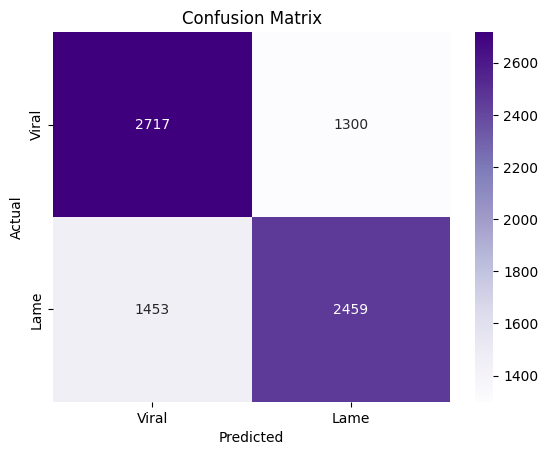

In [220]:
# evaluate linear regression performance
labels = ["Viral","Lame"]

print("Classification Report:\n")
print(classification_report(y_test, y_predict_log, target_names=labels))

cm = confusion_matrix(y_test, y_predict_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Random Forest Classification Report:

              precision    recall  f1-score   support

       viral       0.67      0.66      0.66      4017
        lame       0.66      0.67      0.66      3912

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



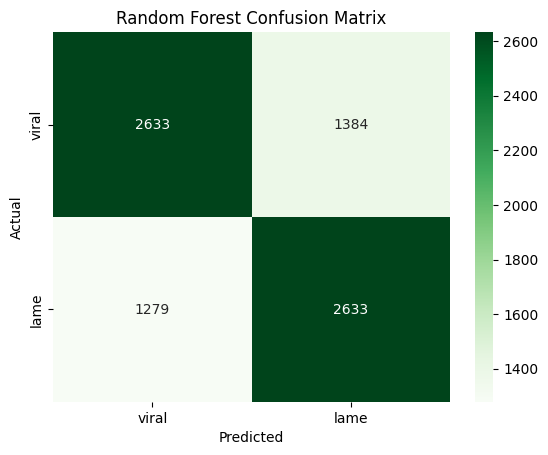

In [ ]:
#CHLOE RANDOM FOREST

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20, 
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_res, y_train_res)

y_predict_rf = rf_model.predict(X_test)
labels = ["viral", "lame"]

#evaluation
print("\nRandom Forest Classification Report:\n")
print(classification_report(y_test, y_predict_rf, target_names=labels))

cm = confusion_matrix(y_test, y_predict_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()
#feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)

#### 2. Neural Network

In [223]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor  = torch.tensor(y_test.to_numpy(), dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [224]:
class ClassificationNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 51),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(51, 26),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(26, num_classes)  # output layer
        )

    def forward(self, x):
        return self.model(x)


In [225]:
model = ClassificationNN(input_dim=X_train_tensor.shape[1], num_classes=3)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Epoch 10/20 | Train Loss: 0.6168 | Test Loss: 0.6328
Epoch 20/20 | Train Loss: 0.6079 | Test Loss: 0.6210
Classification Report:

              precision    recall  f1-score   support

        Lame       0.66      0.65      0.66      4017
       Viral       0.65      0.66      0.65      3912

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



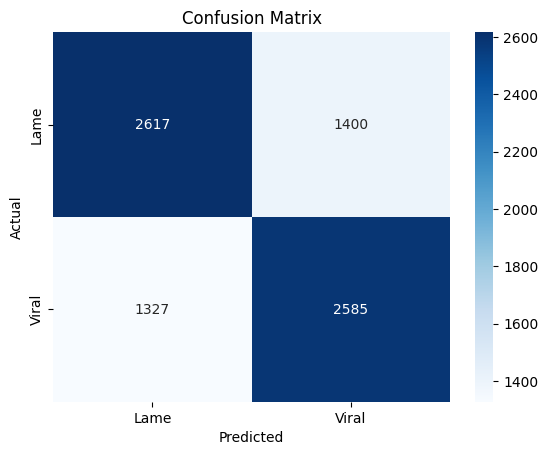

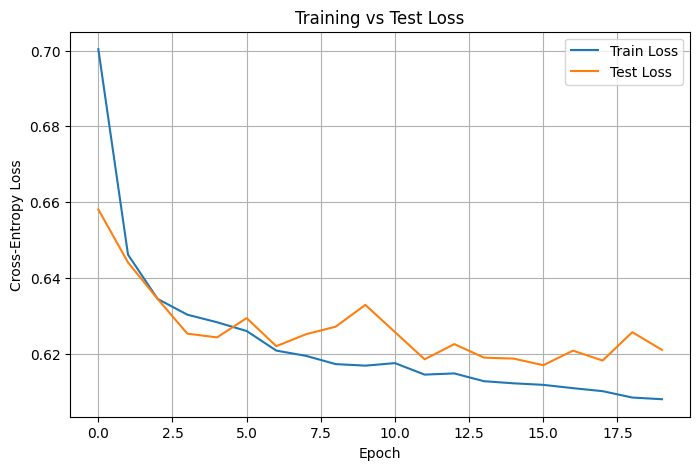

In [ ]:
train_losses = []
test_losses = []

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Test loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)

    test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

#evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1)

labels = ["Lame", "Viral"]

print("Classification Report:\n")
print(classification_report(y_test_tensor.numpy(), y_pred.numpy(), target_names=labels))

cm = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()